In [2]:
!pip install -U scikit-learn==0.21.3 imbalanced-learn

  Using cached https://files.pythonhosted.org/packages/a0/c5/d2238762d780dde84a20b8c761f563fe882b88c5a5fb03c056547c442a19/scikit_learn-0.21.3-cp36-cp36m-manylinux1_x86_64.whl
Requirement already up-to-date: imbalanced-learn in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (0.5.0)
Requirement not upgraded as not directly required: scipy>=0.17.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from scikit-learn==0.21.3) (1.1.0)
Requirement not upgraded as not directly required: numpy>=1.11.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from scikit-learn==0.21.3) (1.14.3)
Requirement not upgraded as not directly required: joblib>=0.11 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from scikit-learn==0.21.3) (0.14.0)
  Found existing installation: scikit-learn 0.21.0
    Uninstalling scikit-learn-0.21.0:
      Successfully uninstalled scikit-learn-0.21.0
You are using pip version 10.0.1, however versio

In [2]:
%matplotlib inline

import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import seaborn as sns
import numpy as np
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.manifold import TSNE

#import autosklearn.classification
from sklearn.metrics import f1_score
from sklearn.preprocessing import QuantileTransformer

In [3]:
def get_x_y(df):
    return df.drop('isFraud', axis=1).values, df.isFraud.values

In [4]:
def undersample(df):
    # undersample dataset
    rus = RandomUnderSampler(random_state=42)
    X, y = rus.fit_resample(df.drop('isFraud', axis=1).values, df.isFraud.values)

    
    return pd.DataFrame(
        data=np.c_[ X, y ],
        columns=np.append( df.drop('isFraud', axis=1).columns.values, 'isFraud')
    )

In [5]:
def plot_classes(df):
    ax = df.groupby(df['isFraud'])['isFraud'].count().plot(kind='bar')
    x_offset = -0.05
    y_offset = 0
    for p in ax.patches:
        b = p.get_bbox()
        val = "{}".format(int(b.y1 + b.y0))
        ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

In [6]:
def plot_tsne(x_, y_):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(x_)
    plt.figure(figsize=(10,10))
    plt.scatter(X_2d[:,0], X_2d[:,1], color=['r' if y==1 else 'g' for y in y_])
    plt.show()

In [7]:
def plot_correlation(df_):
    corr = df_.corr()

    f, ax = plt.subplots(figsize=(15, 8))
    sns.heatmap(corr, annot=True, fmt="f",
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                ax=ax)

In [8]:
def plot_money(df):
    plt.figure(figsize=(20,20))
    plt.subplot(10, 1, 1)
    df[(df.type_id == 0)].amount.plot.line(title='Amount NF')

    plt.subplot(10, 1, 2)
    df[(df.type_id == 1)].amount.plot.line(color='r', title='Amount F')

    plt.subplot(10, 1, 3)
    df[(df.type_id == 0)].oldbalanceOrg.plot.line(title='Old Balance Orig NF')
    plt.subplot(10, 1, 4)
    df[(df.type_id == 1)].oldbalanceOrg.plot.line(color='r',title='Old Balance Orig F')

    plt.subplot(10, 1, 5)
    df[(df.type_id == 0)].newbalanceOrig.plot.line(title='New Balance Orig NF')
    plt.subplot(10, 1, 6)
    df[(df.type_id == 1)].newbalanceOrig.plot.line(color='r',title='New Balance Orig F')


    plt.subplot(10, 1, 7)
    df[(df.type_id == 0)].oldbalanceOrg.plot.line(title='Old Balance Orig NF')
    plt.subplot(10, 1, 8)
    df[(df.type_id == 1)].oldbalanceOrg.plot.line(color='r',title='Old Balance Orig FF')

    plt.subplot(10, 1, 9)
    df[(df.type_id == 0)].newbalanceOrig.plot.line(title='New Balance Orig NF')
    plt.subplot(10, 1, 10)
    df[(df.type_id == 1)].newbalanceOrig.plot.line(color='r',title='New Balance Orig F')

    plt.show()

## Get the dataset if needed

In [9]:
if not os.path.exists('data'):
    !mkdir -p data/
    !aws s3 sync s3://spock.cloud.data/datasets/credit-card/Dataset2/ data/
    !cat data/transactions.training.csv > data/transactions.csv
    !grep -v 'isFraud' data/transactions.test.csv  >> data/transactions.csv 

## Load and prepare the dataset

In [10]:
df = pd.read_csv('data/transactions.csv')

In [11]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


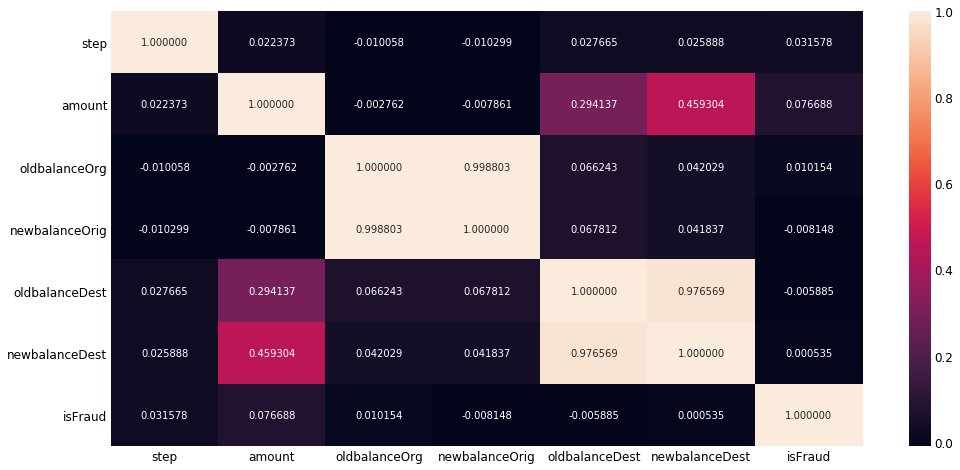

In [12]:
plot_correlation(df)

## Converts type to an enumeration

In [16]:
df['type'] = df['type'].astype('category')
df['type_id'] = df["type"].cat.codes

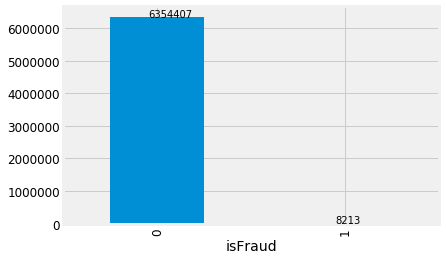

In [17]:
plot_classes(df)

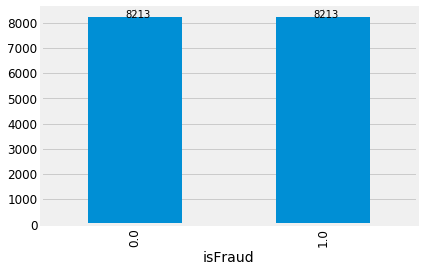

In [18]:
df_ = df.drop(['step', 'type', 'nameOrig', 'nameDest'], axis=1)
df_ = undersample(df_)
plot_classes(df_)

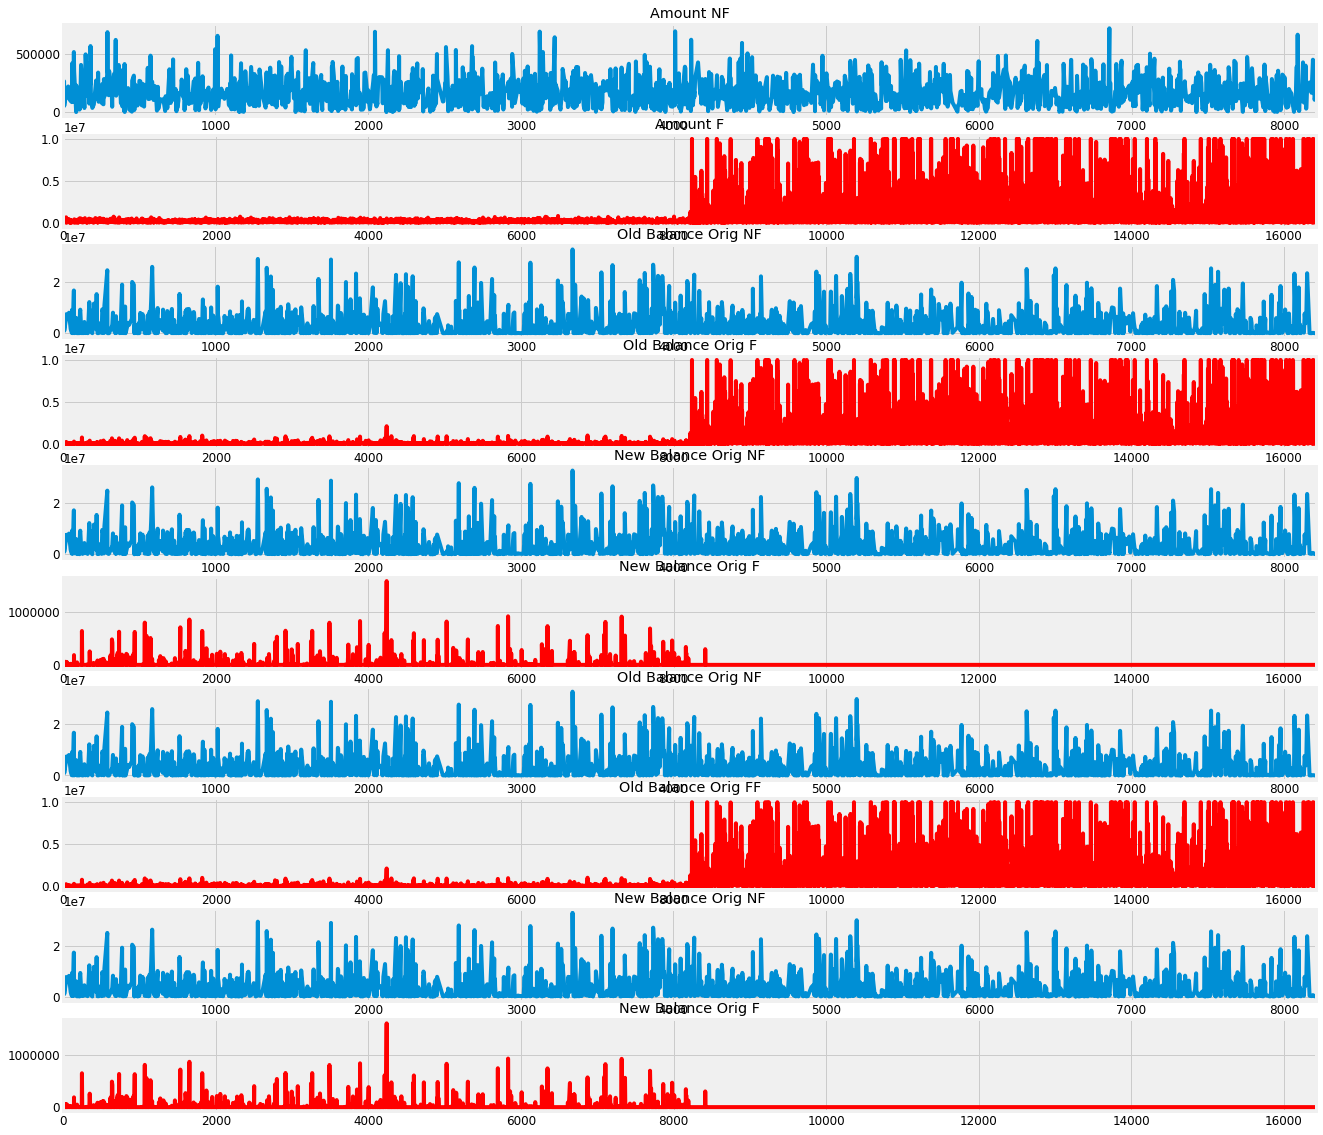

In [19]:
plot_money(df_)

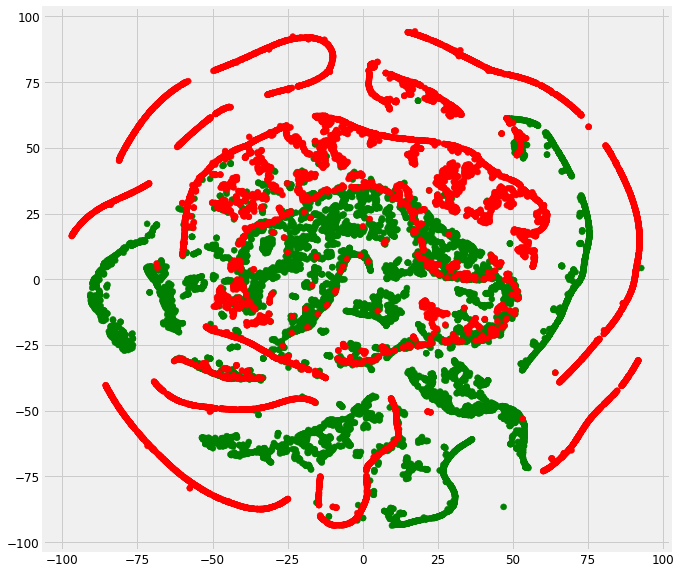

In [20]:
X,y = get_x_y(df_)
plot_tsne(X,y)

...scary...

## ok. now let's compute quantiles for the money

In [67]:
%%time

df__ = df_.copy()
qtf = QuantileTransformer(n_quantiles=10, random_state=0)
cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
qtf.fit(df__[cols].values)
df__[cols] = qtf.transform(df__[cols].values)

df__.type_id = df__.type_id.astype('int')
df__.isFraud = df__.isFraud.astype('int')

CPU times: user 17.1 ms, sys: 27 µs, total: 17.1 ms
Wall time: 15.5 ms


In [68]:
df__.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_id,isFraud
0,0.507163,0.290268,0.000000,0.702775,0.645915,1,0
1,0.006090,0.000000,0.000000,0.000000,0.000000,3,0
2,0.040630,0.292499,0.784223,0.000000,0.000000,3,0
3,0.020046,0.224488,0.778513,0.000000,0.000000,3,0
4,0.586160,0.796019,0.891905,0.889273,0.846874,0,0


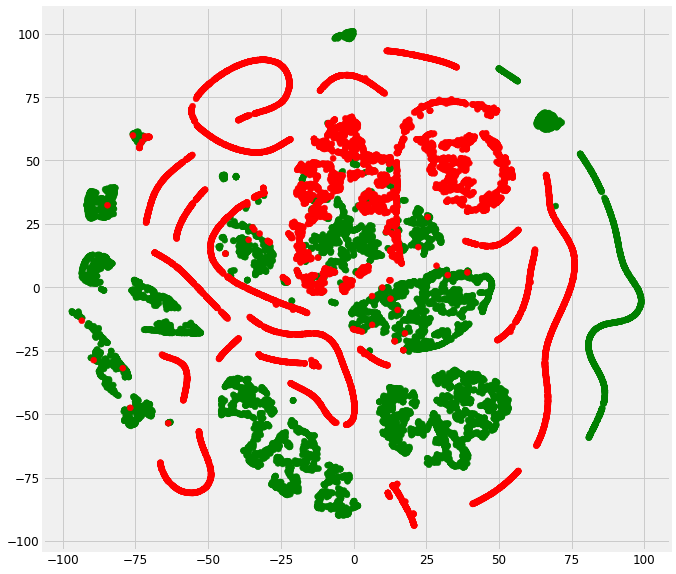

In [66]:
X,y = get_x_y(df__)
plot_tsne(X, y)

...:) better...

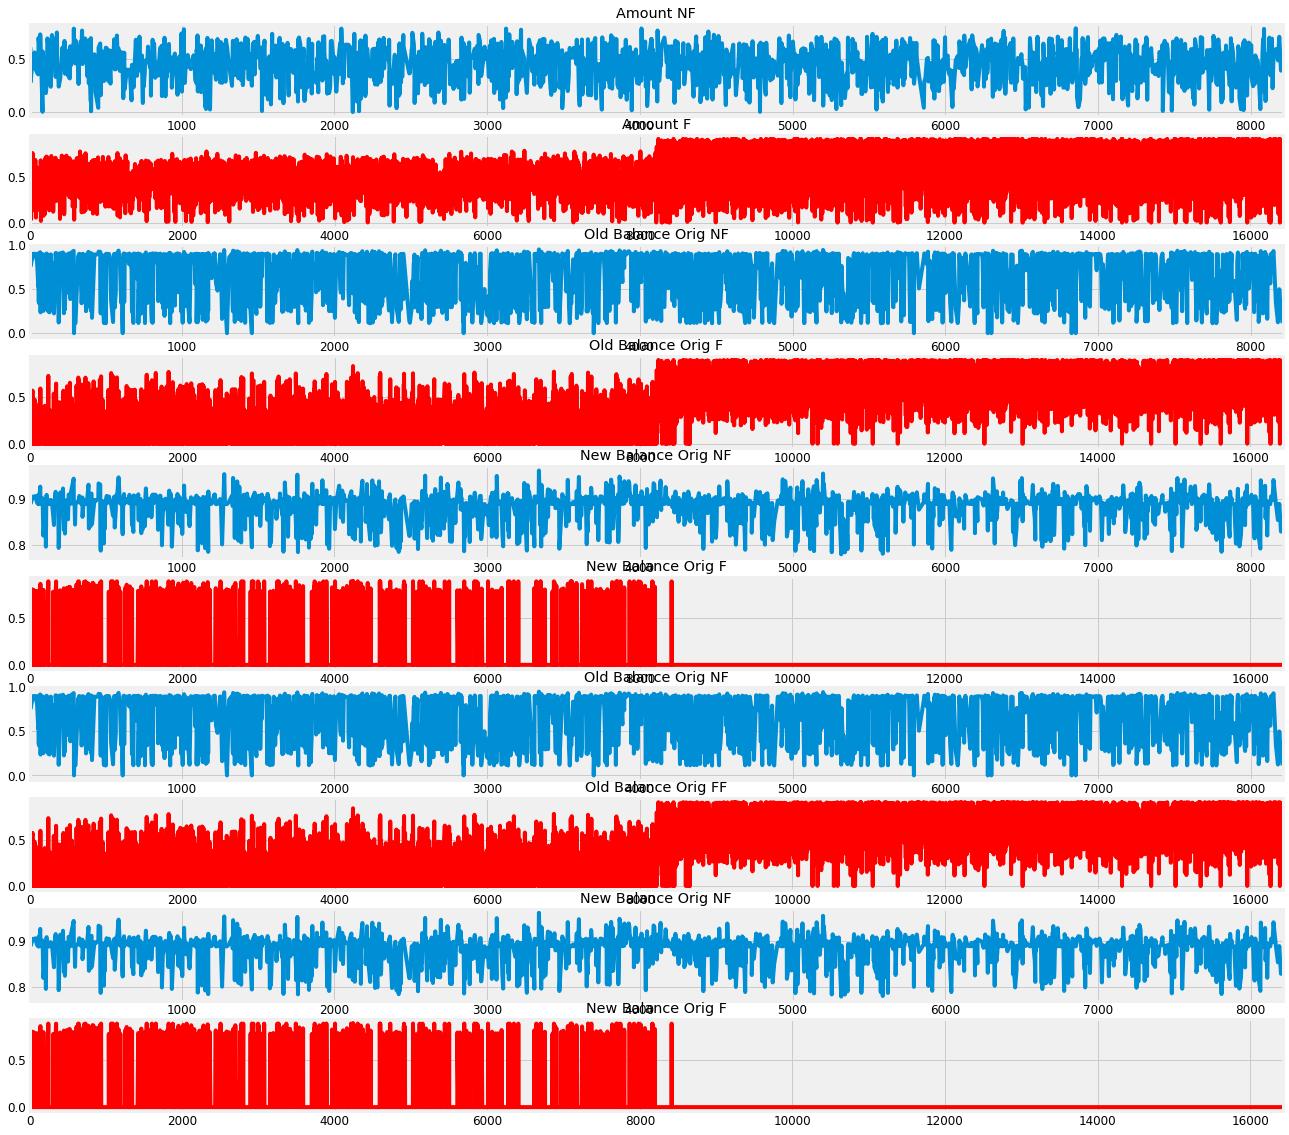

In [64]:
plot_money(df__)

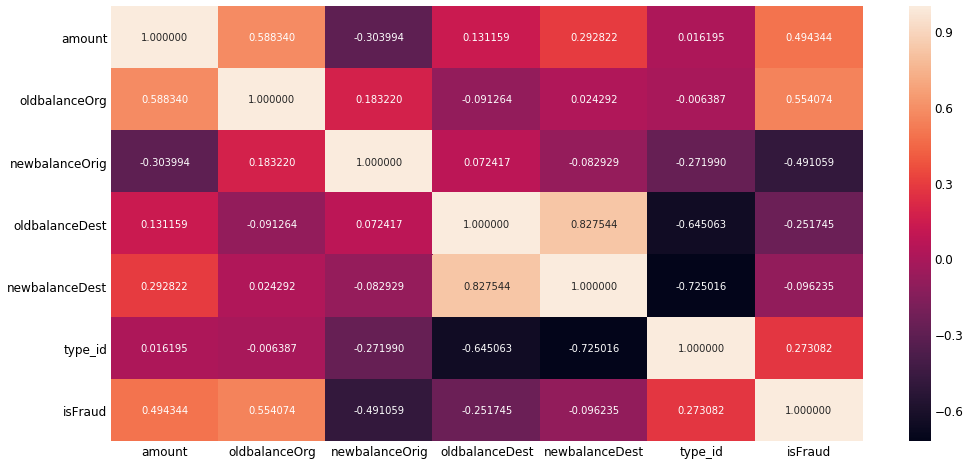

In [65]:
plot_correlation(df__)

## Basic tests

In [69]:
from sklearn.model_selection import train_test_split
X,y = get_x_y(df__)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [70]:
with open('fraud_train.csv', 'w') as csv:
    for x_,y_ in zip(X_train, y_train):
        line = "%s,%s" % (y_, ",".join( list(map(str, x_)) ) )
        csv.write( line + "\n" )
    csv.flush()
    csv.close()

with open('fraud_test.csv', 'w') as csv:
    for x_,y_ in zip(X_test, y_test):
        line = "%s,%s" % (y_, ",".join( list(map(str, x_)) ) )
        csv.write( line + "\n" )
    csv.flush()
    csv.close()

In [71]:
import sagemaker
import boto3

from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

role = get_execution_role()

prefix='fraud_detection'
# Retrieve the default bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

In [72]:
# Upload the dataset to an S3 bucket
input_train = sagemaker_session.upload_data(path='fraud_train.csv', key_prefix='%s/data' % prefix)
input_test = sagemaker_session.upload_data(path='fraud_test.csv', key_prefix='%s/data' % prefix)

In [73]:
train_data = sagemaker.session.s3_input(s3_data=input_train,content_type="csv")
test_data = sagemaker.session.s3_input(s3_data=input_test,content_type="csv")

In [74]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

# Create the estimator
xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)
# Set the hyperparameters
xgb.set_hyperparameters(eta=0.1,
                        max_depth=35,
                        gamma=4,
                        reg_lambda=10,
                        alpha=10,
                        min_child_weight=6,
                        silent=0,
                        objective='binary:logistic',
                        num_round=150)

In [75]:
%%time
# takes around 3min 11s
xgb.fit({'train': train_data, 'validation': test_data, })

2019-10-22 23:01:40 Starting - Starting the training job...
2019-10-22 23:01:43 Starting - Launching requested ML instances......
2019-10-22 23:02:49 Starting - Preparing the instances for training...
2019-10-22 23:03:37 Downloading - Downloading input data...
2019-10-22 23:04:01 Training - Downloading the training image..Arguments: train
[2019-10-22:23:04:15:INFO] Running standalone xgboost training.
[2019-10-22:23:04:15:INFO] File size need to be processed in the node: 1.14mb. Available memory size in the node: 186.15mb
[2019-10-22:23:04:15:INFO] Determined delimiter of CSV input is ','
[23:04:15] S3DistributionType set as FullyReplicated
[23:04:15] 11005x6 matrix with 66030 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-10-22:23:04:15:INFO] Determined delimiter of CSV input is ','
[23:04:15] S3DistributionType set as FullyReplicated
[23:04:15] 5421x6 matrix with 32526 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=


2019-10-22 23:04:26 Uploading - Uploading generated training model
2019-10-22 23:04:26 Completed - Training job completed
Training seconds: 49
Billable seconds: 49
CPU times: user 435 ms, sys: 20.6 ms, total: 456 ms
Wall time: 3min 13s


### Deploy the model and create an endpoint for it
The following action will:
 * get the assets from the job we just ran and then create an input in the Models Catalog
 * create a endpoint configuration (a metadata for our final endpoint)
 * create an enpoint, which is our model wrapped in a format of a WebService
 
After that we'll be able to call our deployed endpoint for doing predictions

In [76]:
%%time
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------!CPU times: user 542 ms, sys: 26.5 ms, total: 569 ms
Wall time: 8min 20s


In [77]:
endpoint_name = xgb_predictor.endpoint
model_name = boto3.client('sagemaker').describe_endpoint_config(
    EndpointConfigName=endpoint_name
)['ProductionVariants'][0]['ModelName']

## Now, let's do a basic test with the deployed endpoint
In this test, we'll use a helper object called predictor. This object is always returned from a **Deploy** call. The predictor is just for testing purposes and we'll not use it inside our real application.

In [78]:
from sagemaker.predictor import csv_serializer
from sklearn.metrics import f1_score

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [79]:
predictions_probs = [ float(xgb_predictor.predict(x).decode('utf-8')) for x in X_test ]
predictions_test = [ True if x >= 0.5 else False for x in predictions_probs ]
score = f1_score(y_test,predictions_test,labels=[True, False],average='micro')

print('F1 Score(micro): %.4f' % (score * 100.0))

F1 Score(micro): 98.8379


## Plot ROC - AUC

In [80]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions_probs)
roc_auc = metrics.auc(fpr, tpr)

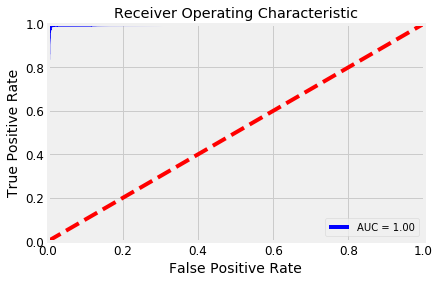

In [81]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Then, let's  test the API for our trained model
This is how your application will call the endpoint. Using boto3 for getting a sagemaker runtime client and then we'll call invoke_endpoint

In [82]:
sm = boto3.client('sagemaker-runtime')

In [86]:
from sagemaker.predictor import csv_serializer

resp = sm.invoke_endpoint(
    EndpointName=endpoint_name,
    CustomAttributes='logistic',
    ContentType='text/csv',
    Body=csv_serializer(X_test[5410])
)
print(resp)
prediction = float(resp['Body'].read().decode('utf-8'))
print('Predicted class: %.14f for [%s]' % (prediction, csv_serializer(X_test[0])) )

{'ResponseMetadata': {'RequestId': 'e460e388-ac45-4498-b1ba-6e1fc10042dd', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'e460e388-ac45-4498-b1ba-6e1fc10042dd', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Tue, 22 Oct 2019 23:22:13 GMT', 'content-type': 'text/csv; charset=utf-8', 'content-length': '14'}, 'RetryAttempts': 0}, 'ContentType': 'text/csv; charset=utf-8', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7f03f9cf6dd8>}
Predicted class: 0.98950654268300 for [0.1473582680403785,0.526949860618258,0.8406083284567112,0.0,0.0,3.0]
